In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import fastai
from fastai import *

In [3]:
import pandas as pd
import pickle

import os
import googletrans

In [4]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [5]:
neg_data = pickle.load(open("neg_translated.pickle","rb"))
neg_data["Target"] = "negative"

pos_data = pickle.load(open("pos_translated.pickle","rb"))
pos_data["Target"] = "positive"

test_data = pickle.load(open("test_translated.pickle","rb"))
test_data["Target"] = "none"

In [6]:
pos_data.columns

Index(['author', 'country', 'crawled', 'domain_rank', 'entities_locations',
       'entities_organizations', 'entities_persons', 'external_links',
       'highlightText', 'highlightTitle', 'language', 'locations',
       'main_image', 'ord_in_thread', 'organizations', 'participants_count',
       'performance_score', 'persons', 'published', 'replies_count',
       'section_title', 'site', 'site_full', 'site_section', 'site_type',
       'social_facebook_comments', 'social_facebook_likes',
       'social_facebook_shares', 'social_gplus_shares',
       'social_linkedin_shares', 'social_pinterest_shares',
       'social_stumbledupon_shares', 'social_vk_shares', 'spam_score', 'title',
       'title_full', 'url', 'uuid', 'lang', 'Translated_text', 'Target'],
      dtype='object')

In [7]:
comp_data = pd.concat([neg_data, pos_data, test_data], axis=0)
comp_data_class = pd.concat([neg_data, pos_data], axis=0)

comp_data = comp_data.rename(columns={"Translated_text":"text"})
comp_data_class = comp_data_class.rename(columns={"Translated_text":"text"})

only_one_no_value = []
for col in comp_data.columns:
    try:
        #print(col,neg_data[col].nunique())
        if comp_data[col].nunique()==1:
            only_one_no_value.append(col)
    except:
        only_one_no_value.append(col)

In [8]:
comp_data["review_site"] = comp_data.section_title.map(lambda x: x.split("|")[0])
comp_data["published"] = pd.to_datetime(comp_data["published"], utc=True)

comp_data["published_year"] = comp_data["published"].dt.year 
comp_data["published_month"] = comp_data["published"].dt.month 
comp_data["published_day"] = comp_data["published"].dt.day 

In [9]:
comp_data_class["review_site"] = comp_data_class.section_title.map(lambda x: x.split("|")[0])
comp_data_class["published"] = pd.to_datetime(comp_data_class["published"], utc=True)

comp_data_class["published_year"] = comp_data_class["published"].dt.year 
comp_data_class["published_month"] = comp_data_class["published"].dt.month 
comp_data_class["published_day"] = comp_data_class["published"].dt.day 

In [10]:
other_col_to_drop = ['crawled', 'section_title','site_full','site_section',
                     'title','title_full', 'url', 'uuid','published','lang']
comp_data = comp_data.drop(only_one_no_value+other_col_to_drop,axis=1)

In [11]:
comp_data_class = comp_data_class.drop(only_one_no_value+other_col_to_drop,axis=1)

In [12]:
comp_data.shape
comp_data.columns

Index(['author', 'country', 'spam_score', 'text', 'Target', 'review_site',
       'published_year', 'published_month', 'published_day'],
      dtype='object')

In [13]:
from sklearn.model_selection import train_test_split
df_trn_1, df_val_1 = train_test_split(comp_data, test_size = 0.20, random_state = 12)

In [14]:
df_trn = pd.DataFrame(columns=["label","text"])
df_trn["label"] = df_trn_1["Target"]
df_trn["text"] = df_trn_1["text"]
df_trn["text"] = df_trn["text"].map(lambda x: str(x))

In [15]:
df_val = pd.DataFrame(columns=["label","text"])
df_val["label"] = df_val_1["Target"]
df_val["text"] = df_val_1["text"]
df_val["text"] = df_val["text"].map(lambda x: str(x))

In [16]:
data_lm = TextLMDataBunch.from_df(path="", train_df=df_trn, valid_df=df_val, bs=32)

In [17]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj great service very friendly will use again and recommend xxbos xxmaj we had an xxmaj antarctic voyage with xxmaj poseidon xxmaj expedition ' s xxmaj sea xxmaj spirits . xxmaj it is a great voyage . xxmaj professional xxmaj expedition xxmaj team , xxmaj nice xxmaj cabin and great service . xxmaj highly xxmaj recommend , and will certainly come back for other voyage again . xxbos i"
1,"order was dealt with xxbos xxmaj great service , quick delivery . xxmaj was my first time using frames direct , will certainly use them again ! xxbos xxmaj penn xxunk 40 xxup ld left hand reel . xxmaj best price in xxup u.k. xxmaj shipping great as well , received reel 1 day after i ordered it xxbos xxmaj shipping always comes before or at the end of their"
2,"is an very professional and compassionate , my dogs did n't want to leave when i came to get them . xxmaj he walked them and made sure their needs were met . i have a very large dog and very tiny one and he was good with both xxbos xxmaj mark from selectquote : gave me a rate that was almost $ 100 cheaper than i had found for"
3,"hat acknowledged let alone i paid for a service i did n't xxmaj receive . xxmaj none the less i would do another i xxunk tour as i like their values etc . xxbos xxmaj drone stated was gps and hd camera but it was n't . xxmaj drone did n't fly straight . xxmaj contacted requesting return address and refund , did n't reply until 4th email and raised"
4,"to choose a method of shipment .. it continues to have an error xxrep 4 . xxunk ! xxbos xxmaj motorcycle xxmaj shippers is on - time and excellent . xxbos xxmaj fast response to all inquiries , and my delivery time has not been long , i was scared to first order due to reading on forums that the delivery time is really long , however , i have"


In [22]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


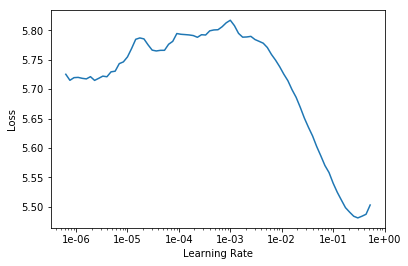

In [24]:
learn.recorder.plot(skip_end=15)

In [25]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.945121,3.787607,0.286955


In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(7, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.686672,3.634620,0.304618
2,3.594723,3.541313,0.315012
3,3.471835,3.479403,0.322373
4,3.354734,3.446886,0.326314
5,3.242784,3.433947,0.328901
6,3.153059,3.433071,0.328956
7,3.101402,3.436435,0.328770


In [ ]:
#learn.save('fit_head')

In [29]:
#learn.save_encoder('/data1/ekta.singh/fine_tuned_enc_translated')

In [143]:
from sklearn.model_selection import train_test_split
df_trn_class_1, df_val_class_1 = train_test_split(comp_data_class, 
                                              stratify = comp_data_class["Target"], 
                                              test_size = 0.20, random_state = 12)

In [144]:
df_trn_class = pd.DataFrame(columns=["label","text"])
df_trn_class["label"] = df_trn_class_1["Target"]
df_trn_class["text"] = df_trn_class_1["text"]
df_trn_class["text"] = df_trn_class["text"].map(lambda x: str(x))

In [145]:
df_val_class = pd.DataFrame(columns=["label","text"])
df_val_class["label"] = df_val_class_1["Target"]
df_val_class["text"] = df_val_class_1["text"]
df_val_class["text"] = df_val_class["text"].map(lambda x: str(x))

In [ ]:
trn_labelcounts = df_trn_class.groupby(["label"]).size()
val_labelcounts = df_val_class.groupby(["label"]).size()

trn_label_sum = len(df_trn_class["label"])
val_label_sum = len(df_val_class["label"])

trn_weights = [count/trn_label_sum for count in trn_labelcounts]
val_weights = [count/val_label_sum for count in val_labelcounts]
trn_weights, val_weights

loss_weights = torch.FloatTensor(trn_weights).cuda()

In [146]:
data_clas = TextDataBunch.from_df(path="", train_df=df_trn_class, valid_df=df_val_class, bs=32, vocab = data_lm.train_ds.vocab)

In [147]:
data_clas.show_batch()

text,target
"xxbos xxmaj cuba xxmaj xxunk \n xxmaj january 15 - 22 , 2017 \n xxmaj day 1 \n xxmaj consider xxmaj cuba : it is a chunk of the xxmaj north xxmaj american xxmaj continent which xxunk 90 miles to the southeast during the third phase of the xxunk of the super - continent xxmaj xxunk 50 million years ago . xxmaj the xxmaj island of xxmaj cuba is",positive
xxbos i ordered a full set of xxmaj xxunk xxmaj high xxmaj back seats for my 2009 xxmaj dodge xxmaj ram xxmaj diesel truck . i was hesitant to purchase because i could n't find a lot of reviews or further info . xxmaj the seats came in and were absolutely wonderful . i set to installing and the instructions were easy - i had no issues with installation .,positive
"xxbos i emailed the below message to customer service and actually got a call back , which was nice . xxmaj they explained the reason for the delay and offered to send a replacement or a credit for the damaged tie . xxmaj in the end , great customer service ( thanks , xxmaj lily ! ) but i still took off a star for having to go through all",positive
"xxbos xxup have xxup o2 xxup dsl / xxup telephone - xxup switched xxup for 4 xxup days - xxup dsl xxup ok - xxup to xxup today , xxup nobody xxup can xxup meet xxup through xxup the xxup fixed xxup network ! xxup there xxup is xxup no xxup possibility xxup by xxup mail xxup xxunk . xxup calling xxup from xxup my xxup mobile xxup radio xxup",negative
"xxbos i was informed that a portion of my flight needs to be moved because the airline cancelled that flight . xxmaj flightnetwork emailed me that i will have to contact them if the change does not suit my schedule , so i did just that . i thought , "" that 's alright they still have plenty of time to find me another flight , i should just concentrate",negative


In [148]:
df_val_class.shape

(25946, 2)

In [157]:
learn = text_classifier_learner(data_clas, drop_mult=0.5, bptt=70)
learn.load_encoder('/data1/user/fine_tuned_enc_translated')
learn.freeze()

In [36]:
#learn.crit = partial(F.cross_entropy, weight=loss_weights) 

In [122]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


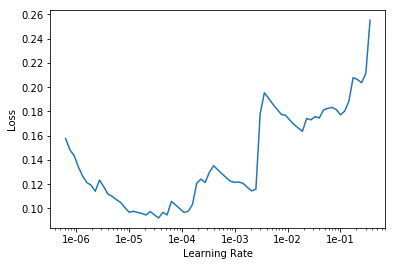

In [123]:
learn.recorder.plot()

In [124]:
learn.fit_one_cycle(1, 2e-6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.091521,0.080139,0.923077


In [127]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.076438,0.033257,1.000000


In [41]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.107972,0.060860,0.979496


In [42]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.065314,0.056926,0.980806
2,0.055844,0.055005,0.981693


In [50]:
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.062573,0.056284,0.981924


In [49]:
#learn.save('/data1/user/fit_class_1')

In [158]:
learn.load('/data1/user/fit_class_1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (103780 items)
[Category positive, Category positive, Category positive, Category positive, Category positive]...
Path: .
x: TextList (103780 items)
[Text xxbos xxmaj excellent service i ordered the part one day and it arrived the next . xxmaj exactly as discribed on the website and a perfect fit . xxmaj the part was very well packed so arrived in new condition . i will use this company again ., Text xxbos xxmaj no problems so far , fast shipping, Text xxbos xxmaj great prices for really good quality items !, Text xxbos xxmaj easy to work with from beginning to end ., Text xxbos xxmaj been waiting for a better price to start a online business i hope i made the right choice and i would recommend this site to every one ❤ it]...
Path: .;

Valid: LabelList
y: CategoryList (25946 items)
[Category positive, Category positive, Category positive, Category negative, Category positive]...
Path: .
x: TextList (25946 items)
[Text

In [159]:
#Get validation predictions
preds, targets = learn.get_preds(ds_type=DatasetType.Valid,ordered=True)

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,1153,159
1,298,24336


In [160]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(targets, predictions)  

0.826490196669432